In [1]:
import torch
import pandas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def load_data(file_path: str) -> tuple:
    """데이터를 불러오는 함수
    Args:
        file_path (str): 데이터 파일의 경로
    Returns:
        X_train, y_train, X_test, y_test
    """
    data = pandas.read_csv(file_path)
    data = data.astype({'G(mg/dL)':'int'})
    X = data.drop('G(mg/dL)', axis=1).values
    y = data['G(mg/dL)'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=87)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return torch.tensor(X_train, dtype=torch.float32), \
        torch.tensor(y_train, dtype=torch.float32), \
        torch.tensor(X_test, dtype=torch.float32), \
        torch.tensor(y_test, dtype=torch.float32)


# 데이터 불러오기
data_S1 = load_data('data/data_S1.csv')
data_S2 = load_data('data/data_S2.csv')
data_S3 = load_data('data/data_S3.csv')

In [2]:
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

batch_size = 1
num_epochs = 3
learning_rate = 0.001

train_loader_S1 = DataLoader(TensorDataset(data_S1[0].unsqueeze(1), data_S1[1]), batch_size=batch_size, shuffle=True)
train_loader_S2 = DataLoader(TensorDataset(data_S2[0].unsqueeze(1), data_S2[1]), batch_size=batch_size, shuffle=True)
train_loader_S3 = DataLoader(TensorDataset(data_S3[0].unsqueeze(1), data_S3[1]), batch_size=batch_size, shuffle=True)

In [3]:
RF_S1=RandomForestClassifier(max_depth=3, n_estimators=100, random_state=0)
GBM_S1 = GradientBoostingClassifier(max_depth=3, n_estimators=100, random_state=0)

RF_S2=RandomForestClassifier(max_depth=3, n_estimators=100, random_state=0)
GBM_S2 = GradientBoostingClassifier(max_depth=3, n_estimators=100, random_state=0)

RF_S3=RandomForestClassifier(max_depth=3, n_estimators=100, random_state=0)
GBM_S3 = GradientBoostingClassifier(max_depth=3, n_estimators=100, random_state=0)

# XGB= XGBClassifier(n_estimators=200, max_depth=4,n_jobs=-1)

In [4]:
for epoch in tqdm(range(num_epochs), desc=f'Train {str}'):
    RF_S1.fit(data_S1[0], data_S1[1])
    GBM_S1.fit(data_S1[0], data_S1[1])
    
    RF_S2.fit(data_S2[0], data_S2[1])
    GBM_S2.fit(data_S2[0], data_S2[1])
    
    RF_S3.fit(data_S3[0], data_S3[1])
    GBM_S3.fit(data_S3[0], data_S3[1])
# XGB.fit(data_L1[0], data_L1[1], eval_metric=["logloss"], verbose=True)

Train <class 'str'>: 100%|███████████████████████████████████████████████████████████████| 3/3 [00:33<00:00, 11.14s/it]


In [5]:
print(RF_S1.score(data_S1[2], data_S1[3]))
print(RF_S2.score(data_S2[2], data_S2[3]))
print(RF_S3.score(data_S3[2], data_S3[3]))

print(GBM_S1.score(data_S1[2],data_S1[3]))
print(GBM_S2.score(data_S2[2],data_S2[3]))
print(GBM_S3.score(data_S3[2],data_S3[3]))

0.9203187250996016
0.7199582027168234
0.9812889812889813
1.0
0.9571577847439916
1.0


In [6]:
import numpy
from sklearn.metrics import mean_squared_error, r2_score

def model_infer(model, loder) -> tuple:
    y_pred = []
    y_true = []

    for X, y in loder:
#         X = X.to(device)
#         y = y.to(device)
        y_hat = model.predict(X.squeeze(0).tolist()) # model(X)
        y_hat = torch.Tensor(y_hat)
        y_pred.append(y_hat.cpu().numpy())
        y_true.append(y.cpu().numpy())
        
    y_pred = numpy.concatenate(y_pred)
    y_true = numpy.concatenate(y_true)
    rms = numpy.sqrt(mean_squared_error(y_true, y_pred.squeeze()))
    r2 = r2_score(y_true, y_pred.squeeze())
    return y_pred, y_true, rms, r2

In [7]:
count = 0
for X, y in train_loader_S2:
    result1 = RF_S2.predict(X.squeeze(0).tolist())
    result2 = GBM_S2.predict(X.squeeze(0).tolist())
    print(result1," : ", result2, " : ", y)
    count += 1
    if count > 5:
        break

[987.]  :  [0.]  :  tensor([0.])
[655.]  :  [655.]  :  tensor([655.])
[655.]  :  [655.]  :  tensor([655.])
[987.]  :  [987.]  :  tensor([987.])
[65.]  :  [65.]  :  tensor([65.])
[987.]  :  [987.]  :  tensor([987.])


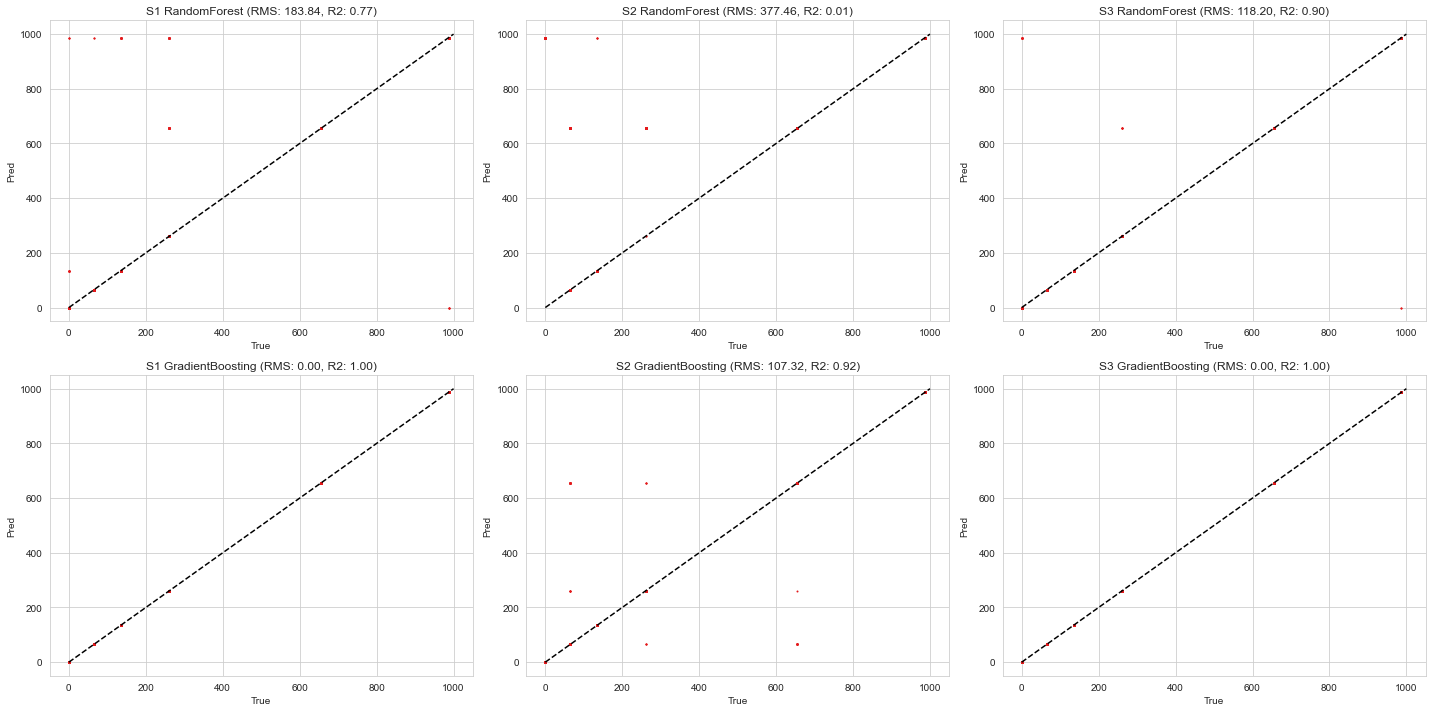

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset

sns.set_style('whitegrid')
sns.set_palette('Set1')

test_loader_S1 = DataLoader(TensorDataset(data_S1[2].unsqueeze(1), data_S1[3]), batch_size=batch_size, shuffle=True)
test_loader_S2 = DataLoader(TensorDataset(data_S2[2].unsqueeze(1), data_S2[3]), batch_size=batch_size, shuffle=True)
test_loader_S3 = DataLoader(TensorDataset(data_S3[2].unsqueeze(1), data_S3[3]), batch_size=batch_size, shuffle=True)

fig, (ax1, ax2) = plt.subplots(2, 3, figsize=(20, 10))
y_pred, y_true, rms, r2 = model_infer(RF_S1, test_loader_S1)
ax1[0].scatter(y_true, y_pred, s=1, label='RandomForest')
ax1[0].plot([0, 1000], [0, 1000], 'k--')
ax1[0].set_xlabel('True')
ax1[0].set_ylabel('Pred')
ax1[0].set_title(f'S1 RandomForest (RMS: {rms:.2f}, R2: {r2:.2f})')

y_pred, y_true, rms, r2 = model_infer(RF_S2, test_loader_S2)
ax1[1].scatter(y_true, y_pred, s=1, label='RandomForest')
ax1[1].plot([0, 1000], [0, 1000], 'k--')
ax1[1].set_xlabel('True')
ax1[1].set_ylabel('Pred')
ax1[1].set_title(f'S2 RandomForest (RMS: {rms:.2f}, R2: {r2:.2f})')

y_pred, y_true, rms, r2 = model_infer(RF_S3, test_loader_S3)
ax1[2].scatter(y_true, y_pred, s=1, label='RandomForest')
ax1[2].plot([0, 1000], [0, 1000], 'k--')
ax1[2].set_xlabel('True')
ax1[2].set_ylabel('Pred')
ax1[2].set_title(f'S3 RandomForest (RMS: {rms:.2f}, R2: {r2:.2f})')

y_pred, y_true, rms, r2 = model_infer(GBM_S1, test_loader_S1)
ax2[0].scatter(y_true, y_pred, s=1, label='GradientBoosting')
ax2[0].plot([0, 1000], [0, 1000], 'k--')
ax2[0].set_xlabel('True')
ax2[0].set_ylabel('Pred')
ax2[0].set_title(f'S1 GradientBoosting (RMS: {rms:.2f}, R2: {r2:.2f})')

y_pred, y_true, rms, r2 = model_infer(GBM_S2, test_loader_S2)
ax2[1].scatter(y_true, y_pred, s=1, label='GradientBoosting')
ax2[1].plot([0, 1000], [0, 1000], 'k--')
ax2[1].set_xlabel('True')
ax2[1].set_ylabel('Pred')
ax2[1].set_title(f'S2 GradientBoosting (RMS: {rms:.2f}, R2: {r2:.2f})')

y_pred, y_true, rms, r2 = model_infer(GBM_S3, test_loader_S3)
ax2[2].scatter(y_true, y_pred, s=1, label='GradientBoosting')
ax2[2].plot([0, 1000], [0, 1000], 'k--')
ax2[2].set_xlabel('True')
ax2[2].set_ylabel('Pred')
ax2[2].set_title(f'S3 GradientBoosting (RMS: {rms:.2f}, R2: {r2:.2f})')

plt.tight_layout()
plt.show()

In [9]:
def load_origin(file_path: str) -> tuple:
    data = pandas.read_csv(file_path)
    X = data.drop('G(mg/dL)', axis=1).values
    y = data['G(mg/dL)'].values

    scaler = StandardScaler()
    X_data = scaler.fit_transform(X)
    
    return data, torch.tensor(X_data, dtype=torch.float32), \
        torch.tensor(y, dtype=torch.float32)

In [10]:
def model_infer_data(model, loder) -> tuple:
    y_pred = []
    for X, y in loder:
        y_hat = model.predict(X.squeeze(0).tolist()) # model(X)
        y_hat = torch.Tensor(y_hat)
        y_pred.append(y_hat.cpu().numpy())
        
    y_pred = numpy.concatenate(y_pred).squeeze().tolist()
    return y_pred

In [11]:
origin1, dataX1, dataY1 = load_origin('data/data_S1.csv')
origin2, dataX2, dataY2 = load_origin('data/data_S2.csv')
origin3, dataX3, dataY3 = load_origin('data/data_S3.csv')
loader1 = DataLoader(TensorDataset(dataX1.unsqueeze(1), dataY1), batch_size=1, shuffle=False)
loader2 = DataLoader(TensorDataset(dataX2.unsqueeze(1), dataY2), batch_size=1, shuffle=False)
loader3 = DataLoader(TensorDataset(dataX3.unsqueeze(1), dataY3), batch_size=1, shuffle=False)

y_pred_RFS1 = model_infer_data(RF_S1, loader1)
y_pred_RFS2 = model_infer_data(RF_S2, loader2)
y_pred_RFS3 = model_infer_data(RF_S3, loader3)

y_pred_GBMS1 = model_infer_data(GBM_S1, loader1)
y_pred_GBMS2 = model_infer_data(GBM_S2, loader2)
y_pred_GBMS3 = model_infer_data(GBM_S3, loader3)

df1 = pandas.DataFrame(origin1, columns=["G(mg/dL)","LD Temp","LD123_Bias_Av","mPD_dS","T-rPD_dS","R-rPD_dS"])
cols = list(df1.columns)
cols = cols[1:] + cols[:1]
df1 = df1[cols]
df1['G RF(mg/dL)'] = y_pred_RFS1
df1['G GB(mg/dL)'] = y_pred_GBMS1

df2 = pandas.DataFrame(origin2, columns=["G(mg/dL)","LD Temp","LD123_Bias_Av","mPD_dS","T-rPD_dS","R-rPD_dS"])
cols = list(df2.columns)
cols = cols[1:] + cols[:1]
df2 = df2[cols]
df2['G RF(mg/dL)'] = y_pred_RFS2
df2['G GB(mg/dL)'] = y_pred_GBMS2

df3 = pandas.DataFrame(origin3, columns=["G(mg/dL)","LD Temp","LD123_Bias_Av","mPD_dS","T-rPD_dS","R-rPD_dS"])
cols = list(df3.columns)
cols = cols[1:] + cols[:1]
df3 = df3[cols]
df3['G RF(mg/dL)'] = y_pred_RFS3
df3['G GB(mg/dL)'] = y_pred_GBMS3


df1 = df1.sample(frac=1)
df2 = df2.sample(frac=1)
df3 = df3.sample(frac=1)

In [12]:
df1.head()

,LD Temp,LD123_Bias_Av,mPD_dS,T-rPD_dS,R-rPD_dS,G(mg/dL),G RF(mg/dL),G GB(mg/dL)
2222,26.906,13.100,981.427641,1273.950511,327.852325,0.000000,0.0,0.0
445,26.853,13.167,978.643718,1078.913104,329.599626,135.994774,135.0,135.0
942,26.853,13.186,978.044697,1424.283825,328.905456,655.807163,655.0,655.0
2023,26.853,13.087,981.455604,1275.291802,328.083252,0.000000,0.0,0.0
2149,26.906,13.100,980.827713,1273.607025,330.043115,0.000000,0.0,0.0


In [13]:
df2.head()

,LD Temp,LD123_Bias_Av,mPD_dS,T-rPD_dS,R-rPD_dS,G(mg/dL),G RF(mg/dL),G GB(mg/dL)
1072,26.853,0.5,0.009537,1103.155685,183.360982,655.807163,655.0,655.0
2937,26.906,0.4,0.003406,1030.822500,183.702958,987.185070,987.0,987.0
2166,26.906,0.4,-0.004768,1201.376083,183.699549,65.699357,655.0,655.0
2096,26.906,0.4,0.009537,1022.254295,183.427749,0.000000,987.0,0.0
13,26.906,0.5,-0.007948,906.147476,182.997008,0.000000,987.0,0.0


In [14]:
df3.head()

,LD Temp,LD123_Bias_Av,mPD_dS,T-rPD_dS,R-rPD_dS,G(mg/dL),G RF(mg/dL),G GB(mg/dL)
2736,26.960,0.4,0.019074,1249.794086,1426.181932,655.807163,655.0,655.0
2679,26.960,0.4,0.038148,1248.779206,1424.496641,655.807163,655.0,655.0
2345,26.960,0.4,0.015895,929.681274,1421.559069,135.994774,135.0,135.0
1394,26.960,0.5,0.028611,1048.790786,1418.760078,987.185070,987.0,987.0
1373,26.906,0.5,0.036104,1048.373218,1418.922970,987.185070,987.0,987.0
